In [5]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3

# required to enable non-blocking interaction:
%gui qt5

import sys
from copy import deepcopy
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from neuropy.utils.result_context import IdentifyingContext
from nptyping import NDArray
import neuropy.utils.type_aliases as types
from collections import defaultdict

import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime

from neuropy.utils.indexing_helpers import PandasHelpers
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.indexing_helpers import partition_df
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)

import IPython
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.assertion_helpers import Assert

# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')

# Switch to the desired interactivity mode
plt.interactive(True)

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import file_uri_from_path, sanitize_filename_for_Windows
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, simple_path_display_widget
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results
from pyphocorehelpers.assertion_helpers import Assert

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import find_csv_files, find_HDF5_files, find_most_recent_files
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_histograms, plot_stacked_histograms

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files, _process_and_load_exported_file, _common_cleanup_operations

from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes

from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import build_session_t_delta, _new_process_csv_files, _old_process_csv_files

debug_print: bool = False
enable_neptune: bool = False

_TODAY_DAY_ONLY_DATE: str = "2024-10-29"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Apogee"
TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_GL"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Lab"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_rMBP"

print(f'TODAY_DAY_DATE: {TODAY_DAY_DATE}')

types.session_str: TypeAlias = str # a unique session identifier

if enable_neptune:
    import neptune # for logging progress and results
    from neptune.types import File
    from pyphoplacecellanalysis.General.Batch.NeptuneAiHelpers import Neptuner, AutoValueConvertingNeptuneRun, set_environment_variables 

    ## Gets the notebook filepath for Neptune:
    import IPython
    from pyphocorehelpers.programming_helpers import IPythonHelpers
    notebook_filepath: str = IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())
    assert Path(notebook_filepath).resolve().exists(), f"found notebook filepath: '{notebook_filepath}' does not exist"
    # notebook_filepath

    neptune_kwargs = {'project':"commander.pho/PhoDibaLongShortAcrossSessions",
    'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}
            
    neptuner = Neptuner(project_name=neptune_kwargs['project'], api_token=neptune_kwargs['api_token'])


    if neptuner.run is None:
        neptuner.run = AutoValueConvertingNeptuneRun(project=neptuner.project_name, api_token=neptuner.api_token, dependencies="infer", source_files=[notebook_filepath])
        params = {"TODAY_DAY_DATE": TODAY_DAY_DATE, "run_workstation": "Apogee"}
        neptuner.run["parameters"] = params
        neptuner.outputs = neptuner.run['outputs']
        neptuner.figures = neptuner.outputs['figures']

    neptuner_run: AutoValueConvertingNeptuneRun = neptuner.run
    
    # run = neptune.init_run(source_files=["**/*.dvc"])

    # # Pre-execution dataframe view:
    # run["dataset/global_batch_run_progress_df"].upload(File.as_html(global_batch_run.to_dataframe(expand_context=True, good_only=False))) # "path/to/test_preds.csv"

else:
    # no neptune:
    neptuner = None    
    neptuner_run = None



known_bad_sessions: List[IdentifyingContext] = UserAnnotationsManager.get_hardcoded_bad_sessions()
# bad_session_df: pd.DataFrame = pd.DataFrame.from_records([v.to_dict() for v in known_bad_sessions], columns=['format_name', 'animal', 'exper_name', 'session_name'])
# bad_session_df

known_bad_session_strs = [str(v.get_description()) for v in known_bad_sessions]
# known_bad_session_strs

Automatic pdb calling has been turned OFF
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TODAY_DAY_DATE: 2024-10-29_GL


# Graphics Imports

In [6]:
import matplotlib
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots
from neuropy.utils.matplotlib_helpers import matplotlib_configuration_update
# matplotlib.use('Qt5Agg')
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults, AcrossSessionTables, AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo

def _save_matplotlib_fig(matplotlib_output_container: MatplotlibRenderPlots):

    a_fig_context = matplotlib_output_container.context
    assert len(matplotlib_output_container.saved_figures) == 1
    a_saved_fig_path = matplotlib_output_container.saved_figures[0][0]
    assert a_saved_fig_path.exists()

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_saved_fig_path.as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        

# %matplotlib inline


# with matplotlib_configuration_update(is_interactive=False, backend='nbAgg'):
# 'collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-06-11_GL.pkl'

In [7]:
import plotly.io as pio
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results, add_copy_save_action_buttons

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
 ## set up figure size
fig_size_kwargs = {'width': (resolution_multiplier * 1800), 'height': (resolution_multiplier*480)}
# fig_size_kwargs = {'width': (resolution_multiplier * 1080), 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()

# assert figure_export_path.exists()

from PIL import Image

from pyphocorehelpers.programming_helpers import copy_image_to_clipboard

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE, figures_folder, neptuner_run
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([TODAY_DAY_DATE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(figure_out_paths['.html'].as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        
    return figure_out_paths


### csv_files

In [8]:
## Load across session t_delta CSV, which contains the t_delta for each session:

## INPUTS: known_bad_session_strs,

# cuttoff_date = datetime(2024, 9, 26)
cuttoff_date = datetime(2024, 10, 28)
# cuttoff_date = datetime(2024, 5, 18)
# cuttoff_date = None


In [9]:

known_collected_outputs_paths = [Path(v).resolve() for v in ['/Users/pho/data/collected_outputs',
                                                            '/Volumes/SwapSSD/Data/collected_outputs', r"K:/scratch/collected_outputs", '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs',
                                                            '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                            '/home/halechr/cloud/turbo/Pho/Output/collected_outputs',
                                                            '/home/halechr/FastData/collected_outputs/',
                                                            ]]
collected_outputs_directory = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_directory.exists(), f"collected_outputs_directory: {collected_outputs_directory} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_directory: {collected_outputs_directory}')


# _active_folder_widget = fullwidth_path_widget(collected_outputs_directory)
# display(_active_folder_widget)

# Create a 'figures' subfolder if it doesn't exist
figures_folder: Path = collected_outputs_directory.joinpath('figures').resolve()
figures_folder.mkdir(parents=False, exist_ok=True)
assert figures_folder.exists()
print(f'\tfigures_folder: {file_uri_from_path(figures_folder)}')

# Create an output path for the across session collected results (like the aggregate CSVs built from the individual session CSVs)
across_sessions_output_folder: Path = collected_outputs_directory.joinpath('../across_sessions').resolve()
across_sessions_output_folder.mkdir(parents=False, exist_ok=True)
assert across_sessions_output_folder.exists()
print(f'\tacross_sessions_output_folder: {file_uri_from_path(across_sessions_output_folder)}')


# ## sessions' t_delta:
# # t_delta_csv_path = collected_outputs_directory.joinpath('../2024-01-18_GL_t_split_df.csv').resolve() # GL
# t_delta_csv_path = collected_outputs_directory.joinpath('../2024-09-25_GL_t_split_df.csv').resolve()
# # Assert.file_e
# t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = build_session_t_delta(t_delta_csv_path=t_delta_csv_path)

if neptuner_run is not None:
    _neptuner_run_parameters = dict(cuttoff_date=cuttoff_date, collected_outputs_directory=collected_outputs_directory.as_posix(), figures_folder=figures_folder.as_posix(),
                           across_sessions_output_folder=across_sessions_output_folder.as_posix(), t_delta_csv_path=t_delta_csv_path.as_posix())
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parameters/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

# ## Find the files:
# csv_files = find_csv_files(collected_outputs_directory)
# h5_files = find_HDF5_files(collected_outputs_directory)

# csv_sessions, parsed_csv_files_df  = find_most_recent_files(found_session_export_paths=csv_files, cuttoff_date=cuttoff_date) # #TODO 2024-09-27 02:01: - [ ] Note `csv_sessions` is unused, replaced by `parsed_csv_files_df`
# h5_sessions, parsed_h5_files_df = find_most_recent_files(found_session_export_paths=h5_files)


collected_outputs_directory: /nfs/turbo/umms-kdiba/Pho/Output/collected_outputs
	figures_folder: file:///nfs/turbo/umms-kdiba/Pho/Output/collected_outputs/figures
	across_sessions_output_folder: file:///nfs/turbo/umms-kdiba/Pho/Output/across_sessions


In [10]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files

final_sessions, sessions_t_delta_tuple, df_results, (parsed_csv_files_df, csv_files, csv_sessions), (parsed_h5_files_df, h5_files, h5_sessions), excluded_or_outdated_files_list = load_across_sessions_exported_files(cuttoff_date=cuttoff_date, debug_print=True)
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df = df_results
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK

collected_outputs_directory: /nfs/turbo/umms-kdiba/Pho/Output/collected_outputs
earliest_delta_aligned_t_start: -2057.225948, latest_delta_aligned_t_end: 1661.856002
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-26_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-11_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-24_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-28_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-22_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-12_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-28_GL_allQClus"
ERR: Could not parse filename: "sessions_experiment_datetime_df"
failed to find proper 'is_user_annotated_epoch' and 'is_valid_epoch' columns for the epochs passed with error: 'is_user_annotated_epoch'. Skipping.
	Setting "is_valid_epoch" all to True and "is_user_annotated_Epoch" all to False.


In [11]:
all_sessions_all_scores_ripple_df

,start,stop,label,duration,P_Long_LR,pearsonr_long_LR,wcorr_long_LR,P_Long_RL,pearsonr_long_RL,wcorr_long_RL,P_Short_LR,pearsonr_short_LR,wcorr_short_LR,P_Short_RL,pearsonr_short_RL,wcorr_short_RL,P_Long,P_Short,P_LR,P_RL,ripple_start_t,long_best_P_decoder,short_best_P_decoder,P_decoder_diff,session_name,time_bin_size,delta_aligned_start_t,pre_post_delta_category,custom_replay_name,P_Long.1,P_Short.1,P_LR.1,P_RL.1,session_experience_rank,session_experience_orientation_rank,is_novel_exposure
0,40.187177,40.488202,0,0.301025,0.336490,-0.010803,0.217800,0.208226,-0.155782,-0.015209,0.281245,0.088591,0.127214,0.174039,-0.002583,0.143401,0.544716,0.455284,0.617735,0.382265,40.187177,0.208226,0.174039,0.034187,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1171.370903,pre-delta,,NaN,NaN,NaN,NaN,2,1,False
1,41.011916,41.359114,1,0.347197,0.244382,-0.049109,-0.086171,0.231486,-0.181998,-0.252270,0.269167,-0.104381,-0.074273,0.254964,-0.166440,-0.114507,0.475869,0.524131,0.513550,0.486450,41.011916,0.231486,0.254964,-0.023477,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1170.546164,pre-delta,,NaN,NaN,NaN,NaN,2,1,False
2,43.429702,43.489729,2,0.060027,0.475823,0.071336,-0.752464,0.476028,-0.413563,-0.476701,0.024069,0.063264,-0.800832,0.024080,-0.471881,-0.705234,0.951851,0.048149,0.499892,0.500108,43.429702,0.475823,0.024069,0.451754,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1168.128378,pre-delta,,NaN,NaN,NaN,NaN,2,1,False
3,44.189868,44.279447,3,0.089579,0.362102,0.269543,0.221370,0.034290,-0.655617,-0.746800,0.551393,0.073586,-0.230263,0.052215,-0.608351,-0.328682,0.396392,0.603608,0.913496,0.086504,44.189868,0.034290,0.052215,-0.017925,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1167.368212,pre-delta,,NaN,NaN,NaN,NaN,2,1,False
4,44.588736,44.829950,4,0.241213,0.244285,-0.222796,-0.376273,0.376579,-0.540547,-0.458901,0.149175,-0.215484,-0.162657,0.229961,-0.453950,-0.620624,0.620864,0.379136,0.393460,0.606540,44.588736,0.244285,0.149175,0.095110,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1166.969344,pre-delta,,NaN,NaN,NaN,NaN,2,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4120,1429.924337,1430.429558,193,0.505221,0.156133,NaN,NaN,0.161893,NaN,NaN,0.334811,NaN,NaN,0.347162,NaN,NaN,0.318026,0.681974,0.490945,0.509055,1429.924337,0.156133,0.334811,-0.178678,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,497.098131,post-delta,,NaN,NaN,NaN,NaN,3,1,False
4121,1435.942904,1436.334707,196,0.391803,0.181630,-0.374742,NaN,0.285290,-0.244800,NaN,0.207366,-0.533240,NaN,0.325714,-0.261510,NaN,0.466920,0.533080,0.388995,0.611005,1435.942904,0.181630,0.207366,-0.025736,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,503.116698,post-delta,,NaN,NaN,NaN,NaN,3,1,False
4122,1437.783184,1437.959609,197,0.176425,0.390369,NaN,NaN,0.178935,NaN,NaN,0.295326,NaN,NaN,0.135370,NaN,NaN,0.569304,0.430696,0.685695,0.314305,1437.783184,0.178935,0.135370,0.043565,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,504.956978,post-delta,,NaN,NaN,NaN,NaN,3,1,False
4123,1445.197729,1445.522931,200,0.325202,0.208319,0.650036,NaN,0.177825,-0.459171,NaN,0.331166,0.652567,NaN,0.282689,-0.338825,NaN,0.386144,0.613856,0.539486,0.460514,1445.197729,0.177825,0.282689,-0.104864,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,512.371523,post-delta,,NaN,NaN,NaN,NaN,3,1,False


In [12]:
all_sessions_MultiMeasure_ripple_df

,P_LR,P_RL,P_Long,P_Short,ripple_idx,ripple_start_t,P_Long_LR,P_Long_RL,P_Short_LR,P_Short_RL,most_likely_decoder_index,start,stop,label,duration,best_decoder_index,long_LR_pf_peak_x_pearsonr,long_RL_pf_peak_x_pearsonr,short_LR_pf_peak_x_pearsonr,short_RL_pf_peak_x_pearsonr,session_name,time_bin_size,delta_aligned_start_t,pre_post_delta_category,is_user_annotated_epoch,is_valid_epoch,custom_replay_name,epoch_idx,long_best_pf_peak_x_pearsonr,short_best_pf_peak_x_pearsonr,wcorr_long_LR,wcorr_long_RL,wcorr_short_LR,wcorr_short_RL,long_best_wcorr,short_best_wcorr,wcorr_abs_diff,pearsonr_abs_diff,session_experience_rank,session_experience_orientation_rank,is_novel_exposure
0,0.617735,0.382265,0.544716,0.455284,0,40.187177,0.336490,0.208226,0.281245,0.174039,0,40.187177,40.488202,0.0,0.301025,1.0,-0.010803,-0.155782,0.088591,-0.002583,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1171.370903,pre-delta,False,True,,0,-0.155782,-0.002583,0.217800,-0.015209,0.127214,0.143401,-0.015209,0.143401,-0.128192,0.153199,2,1,False
1,0.513550,0.486450,0.475869,0.524131,1,41.011916,0.244382,0.231486,0.269167,0.254964,2,41.011916,41.359114,1.0,0.347197,1.0,-0.049109,-0.181998,-0.104381,-0.166440,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1170.546164,pre-delta,False,True,,1,-0.181998,-0.166440,-0.086171,-0.252270,-0.074273,-0.114507,-0.252270,-0.114507,0.137763,0.015558,2,1,False
2,0.499892,0.500108,0.951851,0.048149,2,43.429702,0.475823,0.476028,0.024069,0.024080,1,43.429702,43.489729,2.0,0.060027,3.0,0.071336,-0.413563,0.063264,-0.471881,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1168.128378,pre-delta,False,False,,2,0.071336,0.063264,-0.752464,-0.476701,-0.800832,-0.705234,-0.752464,-0.800832,-0.048368,0.008072,2,1,False
3,0.913496,0.086504,0.396392,0.603608,3,44.189868,0.362102,0.034290,0.551393,0.052215,2,44.189868,44.279447,3.0,0.089579,1.0,0.269543,-0.655617,0.073586,-0.608351,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1167.368212,pre-delta,False,False,,3,-0.655617,-0.608351,0.221370,-0.746800,-0.230263,-0.328682,-0.746800,-0.328682,0.418118,0.047266,2,1,False
4,0.393460,0.606540,0.620864,0.379136,4,44.588736,0.244285,0.376579,0.149175,0.229961,1,44.588736,44.829950,4.0,0.241213,1.0,-0.222796,-0.540547,-0.215484,-0.453950,kdiba_gor01_one_2006-6-08_14-26-15,0.025,-1166.969344,pre-delta,False,True,,4,-0.222796,-0.215484,-0.376273,-0.458901,-0.162657,-0.620624,-0.376273,-0.162657,0.213616,0.007312,2,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4609,0.490945,0.509055,0.318026,0.681974,90,1429.924337,0.156133,0.161893,0.334811,0.347162,3,1429.924337,1430.429558,193.0,0.505221,0.0,NaN,NaN,NaN,NaN,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,497.098131,post-delta,NaN,True,,90,NaN,NaN,0.144354,0.196344,0.130042,0.090989,0.144354,0.130042,0.014312,NaN,3,1,False
4610,0.388995,0.611005,0.466920,0.533080,91,1435.942904,0.181630,0.285290,0.207366,0.325714,3,1435.942904,1436.334707,196.0,0.391803,2.0,-0.374742,-0.244800,-0.533240,-0.261510,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,503.116698,post-delta,NaN,True,,91,-0.374742,-0.533240,-0.163713,0.087238,-0.153128,0.164710,-0.163713,-0.153128,0.010585,-0.158498,3,1,False
4611,0.685695,0.314305,0.569304,0.430696,92,1437.783184,0.390369,0.178935,0.295326,0.135370,0,1437.783184,1437.959609,197.0,0.176425,0.0,NaN,NaN,NaN,NaN,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,504.956978,post-delta,NaN,True,,92,NaN,NaN,-0.483481,-0.336139,-0.520375,-0.388712,-0.336139,-0.388712,-0.052573,NaN,3,1,False
4612,0.539486,0.460514,0.386144,0.613856,93,1445.197729,0.208319,0.177825,0.331166,0.282689,2,1445.197729,1445.522931,200.0,0.325202,2.0,0.650036,-0.459171,0.652567,-0.338825,kdiba_vvp01_two_2006-4-10_12-58-3,0.058,512.371523,post-delta,NaN,True,,93,-0.459171,-0.338825,-0.550524,-0.225709,-0.344900,-0.242926,-0.225709,-0.242926,-0.017217,0.120346,3,1,False


In [14]:
parsed_csv_files_df['custom_replay_name'].unique()

array([''], dtype=object)

In [ ]:

## OUTPUTS: csv_files, csv_sessions, parsed_csv_files_df
## OUTPUTS: h5_files, h5_sessions, parsed_h5_files_df



# # #TODO 2024-03-02 12:12: - [ ] Could add weighted correlation if there is a dataframe for that and it's computed:
# _df_raw_variable_names = ['simple_pf_pearson_merged_df', 'weighted_corr_merged_df']
# _df_variables_names = ['laps_weighted_corr_merged_df', 'ripple_weighted_corr_merged_df', 'laps_simple_pf_pearson_merged_df', 'ripple_simple_pf_pearson_merged_df']

# # # tbin_values_dict = {'laps': self.laps_decoding_time_bin_size, 'ripple': self.ripple_decoding_time_bin_size}
# time_col_name_dict = {'laps': 'lap_start_t', 'ripple': 'ripple_start_t'} ## default should be 't_bin_center'

if neptuner_run is not None:
    _neptuner_run_parameters = dict(csv_files=csv_files, h5_files=h5_files, csv_sessions=csv_sessions, h5_sessions=h5_sessions)
    # _neptuner_run_parameters = _neptuner_run_parameters | dict(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
    #                                  t_delta_df=t_delta_df)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

# all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
# Assert.path_exists(all_session_experiment_experience_csv_path)
# ## NEW `parsed_csv_files_df1-based approach 2024-07-11 - 
# ## INPUTS: parsed_csv_files_df
# dict_results, df_results, excluded_or_outdated_files_list = _new_process_csv_files(parsed_csv_files_df=parsed_csv_files_df, t_delta_dict=t_delta_dict, cuttoff_date=cuttoff_date, known_bad_session_strs=known_bad_session_strs, all_session_experiment_experience_csv_path=all_session_experiment_experience_csv_path, debug_print=False) # , known_bad_session_strs=known_bad_session_strs
# (final_sessions_loaded_laps_dict, final_sessions_loaded_ripple_dict, final_sessions_loaded_laps_time_bin_dict, final_sessions_loaded_ripple_time_bin_dict, final_sessions_loaded_simple_pearson_laps_dict, final_sessions_loaded_simple_pearson_ripple_dict, final_sessions_loaded_laps_wcorr_dict, final_sessions_loaded_ripple_wcorr_dict, final_sessions_loaded_laps_all_scores_dict, final_sessions_loaded_ripple_all_scores_dict) = dict_results
# (all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_laps_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_laps_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df) = df_results

In [ ]:
all_session_experiment_experience_csv_path

In [ ]:
# np.sum(all_sessions_laps_time_bin_df['time_bin_size'].isna())

np.sum(all_sessions_laps_time_bin_df['time_bin_size'] == np.nan)


In [ ]:
all_sessions_laps_time_bin_df['time_bin_size'].nunique()
all_sessions_laps_time_bin_df['session_name'].nunique()

In [ ]:
parsed_csv_files_df

In [ ]:
excluded_or_outdated_files_list

In [ ]:
all_sessions_laps_time_bin_df

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_and_apply_session_experience_rank_csv

all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
Assert.path_exists(all_session_experiment_experience_csv_path)
sessions_df, (experience_rank_map_dict, experience_orientation_rank_map_dict), _callback_add_df_columns = load_and_apply_session_experience_rank_csv(all_session_experiment_experience_csv_path, session_uid_str_sep='_')
df_results = [_callback_add_df_columns(a_df, session_id_column_name='session_name') for a_df in df_results]
all_sessions_all_scores_ripple_df: pd.DataFrame = _callback_add_df_columns(all_sessions_all_scores_ripple_df, session_id_column_name='session_name')


# all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df['session_name']
sessions_df

In [ ]:
(all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_laps_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_laps_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df) = df_results
# [list(a_df.columns) for i, a_df in enumerate(df_results)]
# load_across_sessions_exported_files(

# [a_df.dtypes for i, a_df in enumerate(df_results)]
# all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df

# all_sessions_laps_df
# all_sessions_laps_time_bin_df
all_sessions_simple_pearson_laps_df, all_sessions_wcorr_laps_df


# 🔜🔜 MAJOR: trying to get to the bottom of the basic marginal exports not loading

In [ ]:
# # all output dfs:
# _all_output_dfs_list = [all_sessions_all_scores_ripple_df, all_sessions_laps_time_bin_df, all_sessions_laps_df,
#  all_sessions_wcorr_laps_df, all_sessions_simple_pearson_laps_df, all_sessions_ripple_df, all_sessions_ripple_time_bin_df,
# ]

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionCSVOutputFormat

# Calling the class method with keyword arguments
AcrossSessionCSVOutputFormat.debug_print_discovered_csv_infos(
    all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
    sessions_df=sessions_df,
    all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,
    all_sessions_laps_df=all_sessions_laps_df,
    # all_sessions_wcorr_laps_df=all_sessions_wcorr_laps_df,
    all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,
    all_sessions_ripple_df=all_sessions_ripple_df,
    all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df
)

In [ ]:
all_sessions_laps_time_bin_df

In [ ]:
all_sessions_laps_time_bin_df.groupby(['session_name']).agg(time_bin_size_count=('time_bin_size', 'count'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index()

In [ ]:
test_session_name: str = 'kdiba_gor01_two_2006-6-07_16-40-19'
# all_sessions_laps_df

_prev_loaded_df: pd.DataFrame = deepcopy(all_sessions_laps_df[all_sessions_laps_df['session_name'] == test_session_name]) # time_bin_size is all NaN ... 
_prev_loaded_df

# _prev_loaded_df: pd.DataFrame = deepcopy(all_sessions_laps_time_bin_df[all_sessions_laps_time_bin_df['session_name'] == test_session_name]) # time_bin_size is all NaN ... 
# _prev_loaded_df

In [ ]:
checked_csv_path = Path(r"K:\scratch\collected_outputs\2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(laps_time_bin_marginals_df).csv").resolve()
Assert.path_exists(checked_csv_path)

test_csv_df: pd.DataFrame = pd.read_csv(checked_csv_path)
test_csv_df

test_csv_df['time_bin_size'].unique()

In [ ]:
all_sessions_ripple_time_bin_df

# h5_files

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_h5_files

## INPUTS: h5_sessions, session_dict, cuttoff_date, known_bad_session_strs
parsed_h5_files_df, h5_contexts_paths_dict = load_across_sessions_exported_h5_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date,
                                                                                    known_bad_session_strs=known_bad_session_strs)
h5_session_contexts = list(h5_contexts_paths_dict.keys())
included_h5_paths = list(h5_contexts_paths_dict.values())

if neptuner_run is not None:
    _neptuner_run_parameters = dict(parsed_h5_files_df=parsed_h5_files_df,
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

parsed_h5_files_df
# h5_contexts_paths_dict


In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

included_session_contexts = deepcopy(h5_session_contexts)
included_h5_paths = deepcopy(included_h5_paths)
num_sessions = len(included_session_contexts)
(neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table), output_path_dicts = AcrossSessionTables.build_and_save_all_combined_tables(included_session_contexts, included_h5_paths,
                                                                                                                                                    override_output_parent_path=across_sessions_output_folder, output_path_suffix=f'{TODAY_DAY_DATE}',
                                                                                                                                                    should_restore_native_column_types=True, include_csv=True, include_pkl=True)


if neptuner_run is not None:
    _neptuner_run_parameters = dict(neuron_identities_table=neuron_identities_table, long_short_fr_indicies_analysis_table=long_short_fr_indicies_analysis_table, neuron_replay_stats_table=neuron_replay_stats_table,
                                       num_sessions=num_sessions)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for output_name, a_paths_dict in output_path_dicts.items():
        for format_extension, an_output_path in a_paths_dict.items():
            neptuner_run[f"output_files/{format_extension}/{output_name}"].upload(an_output_path.resolve().as_posix())


# {'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.pkl')},
#  'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.pkl')},
#  'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.pkl')}}

output_path_dicts

## Move the "height" columns to the end
neuron_replay_stats_table = reorder_columns_relative(neuron_replay_stats_table, column_names=['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'], relative_mode='start')

neuron_replay_stats_table


In [ ]:
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults

# # output_path_suffix: str = f'2024-09-11_GL'
# # output_path_suffix: str = f'2024-09-12'
# output_path_suffix: str = f'2024-10-22_GL'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}.pkl'
# across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# # across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
# num_sessions = len(across_sessions_instantaneous_fr_dict)
# print(f'num_sessions: {num_sessions}')


In [ ]:
across_session_inst_fr_computation

In [ ]:
across_sessions_instantaneous_frs_list

In [ ]:
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults

# # matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# # output_path_suffix: str = f'{TODAY_DAY_DATE}'
# # output_path_suffix: str = f'2024-09-11_GL'
# # output_path_suffix: str = f'2024-09-12'
# output_path_suffix: str = f'2024-09-26_GL'
# # output_path_suffix: str = f'2024-10-01'
# print(F'output_path_suffix: {output_path_suffix}')
# AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=False)

# Get filtered for a particular type of replay:

In [4]:
## filter by specific set of replays:
# dfs_list = (all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df)

replay_name: str = ''
# replay_name: str = 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0' # 4307 rows
# replay_name: str = 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0' # 1417 rows, 1437 rows
# replay_name: str = 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0' # 2802 rows, 2831 rows

time_bin_size: float = 0.025
# time_bin_size: float = 0.02
# time_bin_size: float = 0.01
filtered_all_sessions_ripple_df = deepcopy(all_sessions_ripple_df)[(all_sessions_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_ripple_time_bin_df = deepcopy(all_sessions_ripple_time_bin_df)[(all_sessions_ripple_time_bin_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_time_bin_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_MultiMeasure_ripple_df = deepcopy(all_sessions_MultiMeasure_ripple_df)[(all_sessions_MultiMeasure_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_MultiMeasure_ripple_df['time_bin_size'] == time_bin_size)]
# filtered_all_sessions_simple_pearson_ripple_df = deepcopy(all_sessions_simple_pearson_ripple_df)[(all_sessions_simple_pearson_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_simple_pearson_ripple_df['time_bin_size'] == time_bin_size)]
# filtered_all_sessions_wcorr_ripple_df = deepcopy(all_sessions_wcorr_ripple_df)[(all_sessions_wcorr_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_wcorr_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_all_scores_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)[(all_sessions_all_scores_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_all_scores_ripple_df['time_bin_size'] == time_bin_size)]
## OUTPUTS: filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df, filtered_all_sessions_simple_pearson_ripple_df, filtered_all_sessions_wcorr_ripple_df, filtered_all_sessions_all_scores_ripple_df
# filtered_all_sessions_simple_pearson_ripple_df
filtered_all_sessions_all_scores_ripple_df


NameError: name 'all_sessions_ripple_df' is not defined

## Session Enumerations

In [ ]:
dataframes = {
    'all_sessions_ripple_df': all_sessions_ripple_df,
    'all_sessions_ripple_time_bin_df': all_sessions_ripple_time_bin_df,
    'all_sessions_simple_pearson_ripple_df': all_sessions_simple_pearson_ripple_df,
    'all_sessions_wcorr_ripple_df': all_sessions_wcorr_ripple_df,
    'all_sessions_all_scores_ripple_df': all_sessions_all_scores_ripple_df
}

for name, df in dataframes.items():
    unique_time_bin_counts = df.groupby('custom_replay_name')['time_bin_size'].nunique()
    print(f"== '{name}':")
    print(unique_time_bin_counts)


In [ ]:
all_sessions_ripple_df['custom_replay_name'].unique()
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
all_sessions_simple_pearson_ripple_df['custom_replay_name'].unique()
all_sessions_all_scores_ripple_df['custom_replay_name'].unique() 

# ['', 'withOldestImportedReplays-qclu_XX-frateThresh_0.1',
# 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
# 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
# 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0']


all_sessions_all_scores_ripple_df['custom_replay_name'].unique() ## OH no, only this one is missing values

In [ ]:
all_sessions_ripple_df

In [ ]:
# sess_names, replay_names = all_sessions_ripple_df['session_name'].str.split('__') # , maxsplit=1

for a_split in all_sessions_ripple_df['session_name'].str.split('__'):
	print(f'a_split: {a_split}')

	if len(a_split) > 1:
		print(f'a_split: {a_split}')


In [ ]:
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
# all_sessions_ripple_df['custom_replay_name'].unique()

In [ ]:
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.show_dimensions', True)

with pd.option_context('display.min_rows', 50, 'display.show_dimensions', True):
    # max_elements
    display(parsed_csv_files_df)

# parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']


In [ ]:
parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']

# all_sessions_all_scores_ripple_df


In [ ]:
all_sessions_ripple_time_bin_df

In [ ]:
print(list(np.unique(parsed_csv_files_df.file_type))) # ['laps_marginals_df', 'laps_simple_pf_pearson_merged_df', 'laps_time_bin_marginals_df', 'laps_weighted_corr_merged_df', 'merged_complete_epoch_stats_df', 'ripple_all_scores_merged_df', 'ripple_marginals_df', 'ripple_simple_pf_pearson_merged_df', 'ripple_time_bin_marginals_df', 'ripple_weighted_corr_merged_df']

# Across Session CSV Outputs

In [ ]:
## INPUTS: parsed_csv_files_df, TODAY_DAY_DATE
display(parsed_csv_files_df)

across_sessions_parsed_csv_files_path = across_sessions_output_folder.joinpath(f'{TODAY_DAY_DATE}_parsed_csv_files_df.csv').resolve()
# parsed_csv_files_df.to_clipboard(excel=True)
parsed_csv_files_df.to_csv(across_sessions_parsed_csv_files_path)
display(fullwidth_path_widget(across_sessions_parsed_csv_files_path, file_name_label='across_sessions_parsed_csv_files_path:'))

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import export_across_session_CSVs

## INPUTS: df_results
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df = df_results
final_across_session_summary_CSVs_output_path = across_sessions_output_folder.resolve()
display(fullwidth_path_widget(final_across_session_summary_CSVs_output_path, file_name_label='final_across_session_summary_CSVs_output_path:'))
final_csv_export_paths = export_across_session_CSVs(final_output_path=final_across_session_summary_CSVs_output_path, TODAY_DAY_DATE=TODAY_DAY_DATE,
                                                    all_sessions_laps_df=all_sessions_laps_df,  all_sessions_ripple_df=all_sessions_ripple_df,
                                                    all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df, 
                                                    # all_sessions_simple_pearson_laps_df=all_sessions_simple_pearson_laps_df,  all_sessions_simple_pearson_ripple_df=all_sessions_simple_pearson_ripple_df,
                                                    all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,  all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
                                                    all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,  all_sessions_all_scores_laps_df=None,
                                                )

# final_csv_export_paths: {'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-Epoch.csv'),
#  'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
#  'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
#  'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
#  'AcrossSession_SimplePearson_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Laps_per-Epoch.csv'),
#  'AcrossSession_SimplePearson_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Ripple_per-Epoch.csv'),
#  'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

if neptuner_run is not None:
    _neptuner_run_parameters = dict(across_sessions_parsed_csv_files_path=across_sessions_parsed_csv_files_path.as_posix(), final_across_session_summary_CSVs_output_path=final_across_session_summary_CSVs_output_path.as_posix(),
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'output_files/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for k, v in final_csv_export_paths.items():
        neptuner_run[f"output_files/{k}"].upload(v.resolve().as_posix())
        
    neptuner_run.sync()
    
final_csv_export_paths

# 2024-03-02 - Get only the user-annotated ripples:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import _split_user_annotated_ripple_df

## Bump
# input_df = all_sessions_simple_pearson_ripple_df
# input_df = all_sessions_all_scores_ripple_df

all_sessions_all_scores_ripple_df, (valid_ripple_df, invalid_ripple_df), (user_approved_ripple_df, user_rejected_ripple_df) = _split_user_annotated_ripple_df(all_sessions_all_scores_ripple_df)

## 2024-03-14 - 'is_valid_epoch' column
# 'is_valid_epoch'
## OUTPUTS: valid_ripple_df, invalid_ripple_df, user_approved_ripple_df, user_rejected_ripple_df, (user_annotated_epoch_unique_session_names, unannotated_session_names)
user_approved_ripple_df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
# df: pd.DataFrame = deepcopy(all_sessions_user_annotated_ripple_df)
df: pd.DataFrame = deepcopy(valid_ripple_df) # valid epochs, but not just those that the user approved
# df: pd.DataFrame = deepcopy(user_approved_ripple_df)

## INPUTS: df

min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

# is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_large_wcorr_diff = np.any((df[['wcorr_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# wcorr_long_LR


In [ ]:
all_sessions_all_scores_ripple_df.time_bin_size.unique() # does not seem to return NaNs

In [ ]:
all_sessions_ripple_time_bin_df.time_bin_size.unique()

In [ ]:
all_sessions_ripple_time_bin_df

### Single-time bin size version:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_single_time_bin_size_dfs

# Select the periods:
# active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = filtered_all_sessions_all_scores_ripple_df, (filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df)

# target_time_bin_size: float = np.nan
# target_time_bin_size: float = 0.005 # 0.025 # 0.08222222
# target_time_bin_size: float = 0.02
target_time_bin_size: float = 0.025

## INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=active_all_sessions_all_scores_ripple_df,
                                                                                                            all_sessions_epochs_df=active_all_sessions_ripple_df, all_sessions_epochs_time_bin_df=active_all_sessions_ripple_time_bin_df, target_time_bin_size=target_time_bin_size,
                                                                                                            included_columns = ['delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch'])

                                                                                                            
single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=all_sessions_MultiMeasure_laps_df,
                                                                                                            all_sessions_epochs_df=all_sessions_laps_df, all_sessions_epochs_time_bin_df=all_sessions_laps_time_bin_df, target_time_bin_size=target_time_bin_size,
                                                                                                            included_columns = ['delta_aligned_start_t',])

## OUTPUTS: single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df
## OUTPUTS: single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df 

# single_time_bin_size_all_sessions_laps_df
# single_time_bin_size_all_sessions_ripple_df

# single_time_bin_size_all_sessions_laps_time_bin_df
# single_time_bin_size_all_sessions_ripple_time_bin_df

In [ ]:
# INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
all_sessions_ripple_df

In [ ]:
all_sessions_ripple_time_bin_df

# 🟢 2024-03-28 - AcrossSessionTable (PhoDibaPaper2023 formats) .h5 and figure exports

neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table: all tables of the same length, one entry per neuron

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables, AcrossSessionsResults, AcrossSessionsVisualizations
from neuropy.utils.mixins.HDF5_representable import HDF_Converter
from pyphoplacecellanalysis.General.Batch.runBatch import BatchResultDataframeAccessor

# output_path_suffix: str = '2024-09-26'
# output_path_suffix: str = '2024-10-22'
output_path_suffix: str = '2024-10-22'
# output_path_suffix: str = '2024-10-04'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}.pkl'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0009.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0015.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0025.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.025.pkl' # single time bin size
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_1000.0.pkl' # single time bin size

## INPUTS: included_session_contexts, included_h5_paths
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.build_all_known_tables(included_session_contexts, included_h5_paths, should_restore_native_column_types=True)

## different than load_all_combined_tables, which seems to work with `long_short_fr_indicies_analysis_table`
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=True)

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{output_path_suffix}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
# num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
# print(f'num_sessions: {num_sessions}')
num_sessions: int = len(long_short_fr_indicies_analysis_table['session_uid'].unique())
print(f'num_sessions: {num_sessions}')

inst_fr_output_load_filepath: Path = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve() # single time bin size # non-instantaneous version
assert inst_fr_output_load_filepath.exists()
# inst_fr_output_filename: str = inst_fr_output_load_filepath.name
# across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=global_data_root_parent_path, inst_fr_output_filename=inst_fr_output_filename)
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=inst_fr_output_load_filepath.parent, inst_fr_output_filename=inst_fr_output_filename)

graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=False, output_override_path=Path('../../output'), inst_fr_output_filename=inst_fr_output_filename)

num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

# Convert byte strings to regular strings
neuron_replay_stats_table = neuron_replay_stats_table.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
neuron_replay_stats_table

### Figure Generation

In [ ]:
long_short_fr_indicies_analysis_table

In [ ]:
neuron_identities_table

In [ ]:
neuron_replay_stats_table

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_bar_graph_t_tests

LxC_Laps_T_result, SxC_Laps_T_result, LxC_Replay_T_result, SxC_Replay_T_result = pho_stats_bar_graph_t_tests(across_session_inst_fr_computation)

# LxC_Laps_T_result: TtestResult(statistic=5.550057784140024, pvalue=4.394229331160663e-05, df=16)
# SxC_Laps_T_result: TtestResult(statistic=-4.50982955925142, pvalue=0.001125880142367611, df=10)
# LxC_Replay_T_result: TtestResult(statistic=-0.4086778656072959, pvalue=0.6881937588138113, df=16)
# SxC_Replay_T_result: TtestResult(statistic=-3.551930809035679, pvalue=0.0052513298000637825, df=10)



# LxC_Replay_T_result is NOT p<0.05 significant (pvalue=0.6882)
# SxC_Replay_T_result IS NOT p<0.05 significant (pvalue=0.0052513298000637825)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations

# %matplotlib inline 
# %matplotlib qt5
## Plotting:
graphics_output_dict = {}

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

## 2023-10-04 - Run `AcrossSessionsVisualizations` corresponding to the PhoDibaPaper2023 figures for all sessions
## Hacks the `PaperFigureTwo` and `InstantaneousSpikeRateGroupsComputation`
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=False, enable_hover_labels=False, enabled_point_connection_lines=True, save_figure=False)


In [ ]:
plt.show()


In [ ]:
# across_session_inst_fr_computation
## Document `InstantaneousSpikeRateGroupsComputation`
from pyphocorehelpers.print_helpers import DocumentationFilePrinter
from pyphocorehelpers.print_helpers import print_keys_if_possible

doc_output_parent_folder = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation').resolve()
Assert.path_exists(doc_output_parent_folder)
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='InstantaneousSpikeRateGroupsComputation')
doc_printer.save_documentation('InstantaneousSpikeRateGroupsComputation', across_session_inst_fr_computation, non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='SingleBarResult')
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[0], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[1], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[2], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[3], non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
across_session_inst_fr_computation.get_summary_dataframe()

In [ ]:
across_sessions_instantaneous_frs_list


### 2024-09-10 - TODO: Filter out the datapoints from the bar plot corresponding to the novel vs. non-novel sessions

In [ ]:
import re
from typing import List, Tuple
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import ConciseSessionIdentifiers

# `across_session_inst_fr_computation.Fig2_Replay_FR`

novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)
non_novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)

# [0] and [1] both only use LxC_aclus
LxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[0].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_LxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[1].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _LxC_aclus_alt == LxC_aclus

# [2] and [3] both only use SxC_aclus
SxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[2].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_SxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[3].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _SxC_aclus_alt == SxC_aclus

parsed_LxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(LxC_aclus)
# parsed_LxC_aclus_df

parsed_SxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(SxC_aclus)
# parsed_SxC_aclus_df

# novel_LxC_indicies, non_novel_LxC_indicies = 
# partition_df(parsed_LxC_aclus_df, partitionColumn='is_session_novel')
# partition_df(parsed_SxC_aclus_df, partitionColumn='is_session_novel')

novel_LxC_indicies = np.where(parsed_LxC_aclus_df['is_session_novel'])[0]
non_novel_LxC_indicies = np.where(np.logical_not(parsed_LxC_aclus_df['is_session_novel']))[0]

(novel_LxC_indicies, non_novel_LxC_indicies)

novel_SxC_indicies = np.where(parsed_SxC_aclus_df['is_session_novel'])[0]
non_novel_SxC_indicies = np.where(np.logical_not(parsed_SxC_aclus_df['is_session_novel']))[0]

(novel_SxC_indicies, non_novel_SxC_indicies)

## OUTPUTS: (novel_LxC_indicies, non_novel_LxC_indicies), (novel_SxC_indicies, non_novel_SxC_indicies)
curr_idx: int = 0
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 1
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 2
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]
curr_idx: int = 3
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]

across_session_inst_fr_computation.Fig2_Replay_FR = novel_Fig2_Replay_FR

In [ ]:
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=True, enable_hover_labels=False, save_figure=False)

In [ ]:
## group by 'is_novel_exposure'
## for `long_short_fr_indicies_analysis_table`
is_novel_partitioned_dfs = dict(zip(*partition_df(long_short_fr_indicies_analysis_table, partitionColumn='is_novel_exposure')))
novel_session_uids = is_novel_partitioned_dfs[True]['session_uid'].unique().tolist()
non_novel_session_uids = is_novel_partitioned_dfs[False]['session_uid'].unique().tolist()
## build dicts:
novel_only_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') in novel_session_uids}
non_novel_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') not in novel_session_uids}
# novel_only_inst_fr_dict

In [ ]:
# all
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)
# split based on session novelty:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[True], num_sessions=len(novel_session_uids), save_figure=False)
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[False], num_sessions=len(non_novel_session_uids), save_figure=False)


In [ ]:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions, save_figure=True)


In [ ]:
## Aggregate across all of the sessions to build a new combined `InstantaneousSpikeRateGroupsComputation`, which can be used to plot the "PaperFigureTwo", bar plots for many sessions.
global_multi_session_context = IdentifyingContext(format_name='kdiba', num_sessions=num_sessions) # some global context across all of the sessions, not sure what to put here.



In [ ]:
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')

plt.show()


In [ ]:
plt.close('all')    

In [ ]:
np.sqrt(2)

In [ ]:

# ax_histdiagonal.



In [ ]:
max_num_bins = np.max(diagonal_hist_artist[0])
max_num_bins
# diagonal_hist_artist[1]

In [ ]:

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
matplotlib_output_container: MatplotlibRenderPlots = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)

In [ ]:
duplicates = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


In [ ]:
print(long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].std())


In [ ]:

# long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index']) # long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index'])
# Compute correlation and p-value
df_cleaned: pd.DataFrame = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].dropna()
df_cleaned

print(df_cleaned.shape)
corr, p_value = pearsonr(df_cleaned['x_frs_index'], df_cleaned['y_frs_index'])
print(f"Correlation: {corr}, P-value: {p_value}")
# Correlation: 0.48548405144431905, P-value: 1.0243398539233502e-48



In [ ]:
plt.close('all')

In [ ]:
graphics_output_dict.saved_figures[0][0] #.plot_data['saved_figures']

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard

fig_to_clipboard(fig)


In [ ]:
# copy_image_to_clipboard(graphics_output_dict['figures'][0])
fig_to_clipboard(matplotlib_output_container.figures[0])

In [ ]:
matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
graphics_output_dict = AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions)

In [ ]:
_save_matplotlib_fig(graphics_output_dict)


In [ ]:
## Load the saved across-session results:
# Outputs: across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list, neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table

BATCH_DATE_TO_USE = f'2024-10-22'
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'

inst_fr_output_file = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve()
Assert.path_exists(inst_fr_output_file)

across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{BATCH_DATE_TO_USE}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')
# neuron_replay_stats_table


In [ ]:
neptuner.stop()

## 2024-09-04 - Batch Output Files

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.Filesystem.metadata_helpers import FilesystemMetadata, get_file_metadata
from pyphocorehelpers.Filesystem.path_helpers import discover_data_files, generate_copydict, copy_movedict, copy_file, save_copydict_to_text_file, read_copydict_from_text_file, invert_filedict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_str_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import check_output_h5_files, copy_files_in_filelist_to_dest
from pyphoplacecellanalysis.General.Batch.runBatch import ConcreteSessionFolder, BackupMethods

# a_batch_progress_df = included_session_batch_progress_df.copy()
included_session_contexts
h5_contexts_paths_dict
# h5_session_contexts

debug_print = False
known_global_data_root_parent_paths = [Path(r'/nfs/turbo/umms-kdiba/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/Volumes/MoverNew/data')] # , Path(r'/home/halechr/FastData'), Path(r'/home/halechr/turbo/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data')
global_data_root_parent_path = find_first_extant_path(known_global_data_root_parent_paths)
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
## Build Pickle Path:
# Hardcoded included_session_contexts:
included_session_contexts = UserAnnotationsManager.get_hardcoded_good_sessions()
good_session_concrete_folders = ConcreteSessionFolder.build_concrete_session_folders(global_data_root_parent_path, included_session_contexts)

# Output Paths:
included_h5_paths = [get_file_str_if_file_exists(v.pipeline_results_h5) for v in good_session_concrete_folders]
# copy_dict = ConcreteSessionFolder.build_backup_copydict(good_session_concrete_folders, backup_mode=BackupMethods.RenameInSourceDirectory, only_include_file_types=['local_pkl', 'global_pkl'])
check_output_h5_files(included_h5_paths)

## OUTPUTS: included_h5_paths, included_session_contexts, good_session_concrete_folders

included_h5_paths

RESULT_DATE_TO_USE = '2024-10-23'
# RESULT_DATE_TO_USE = '2024-07-02'

# included_file_types_paths_dict = {'h5': included_h5_paths, 'recomputed_inst_fr_comps': []}
# included_file_types_paths_dict['recomputed_inst_fr_comps'] = [get_file_path_if_file_exists(v.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.h5').resolve()) for v in good_session_concrete_folders]
# included_file_types_paths_dict


# Plotting via Plotly
`!pip install kaleido=="v0.1.0.post1" `

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter

is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)

@function_attributes(short_name=None, tags=['CRITICAL', 'FINAL', 'plotly'], input_requires=[], output_provides=[], uses=['plotly_pre_post_delta_scatter'], used_by=[], creation_date='2024-10-23 20:04', related_items=[])
def _perform_plot_pre_post_delta_scatter(data_context: IdentifyingContext, concatenated_ripple_df: pd.DataFrame, is_dark_mode: bool=False, enable_custom_widget_buttons:bool=True):
    """ plots the stacked histograms for both laps and ripples
    """
    
    is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=is_dark_mode)
    
    histogram_bins = 25
    num_sessions = 1

    # .025 .03 .044 .05 .058
    # Define the legend groups you want to hide on startup
    legend_groups_to_hide = ['0.03', '0.044', '0.05'] # '0.025', , '0.058'

    # variable_name = 'P_LR'
    # variable_name = 'P_Long'
    variable_name = 'P_Short' # Shows expected effect - short-only replay prior to delta and then split replays post-delta
    # variable_name = 'short_best_wcorr'
    # variable_name = 'long_best_pf_peak_x_pearsonr'
    # variable_name = 'long_best_jump'
    # variable_name = 'wcorr_abs_diff'
    # variable_name = 'short_best_wcorr'
    # variable_name = 'wcorr_long_LR'
    # variable_name = 'pearsonr_abs_diff'
    # variable_name = 'direction_change_bin_ratio_diff'
    # variable_name = 'longest_sequence_length_ratio_diff'
    # variable_name = 'long_best_longest_sequence_length_ratio'
    # variable_name = 'long_best_congruent_dir_bins_ratio'
    # variable_name = 'congruent_dir_bins_ratio_diff'
    # variable_name = 'total_congruent_direction_change_diff'
    # variable_name = 'long_best_congruent_dir_bins_ratio'
    # variable_name = 'long_best_direction_change_bin_ratio'
    # variable_name = 'long_best_congruent_dir_bins_ratio'

    y_baseline_level: float = 0.5 # for P(short), etc
    # y_baseline_level: float = 0.0 # for wcorr, etc

    # px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
    px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"{data_context.get_description(subset_includelist=['dataframe_name', 'title_prefix'], separator=' - ')} - '{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
    px_scatter_kwargs['color'] = "time_bin_size"
    # px_scatter_kwargs.pop('color')

    concatenated_ripple_df['dummy_column_for_size'] = 1.0
    px_scatter_kwargs['size'] = "dummy_column_for_size"
    px_scatter_kwargs['size_max'] = 3
    # px_scatter_kwargs['marker'] = dict(line=dict(width=0))
    # Remove the white border around scatter points by setting line width to 0
    # px_scatter_kwargs['line_width'] = 0  # <---- Correct way for Plotly Express

    # px_scatter_kwargs.update(dict(marginal_x="histogram", marginal_y="rug"))

    hist_kwargs = dict(color="time_bin_size")
    # hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
    # hist_kwargs.pop('color')
    new_fig, new_fig_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, data_context=data_context,
                            out_scatter_fig=None, histogram_bins=histogram_bins,
                            px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                            time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), legend_title_text=None, is_dark_mode=is_dark_mode,
                            # figure_sup_huge_title_text=data_context.get_description(subset_excludelist=['title_prefix'], separator=' | '),
                            figure_sup_huge_title_text=data_context.get_description(subset_includelist=['epochs_name', 'data_grain', 'dataframe_name'], separator=' | '),
)

    new_fig = new_fig.update_layout(fig_size_kwargs)

    if legend_groups_to_hide is not None:
        # Collect all unique legend groups you want to hide
        hidden_groups = set(legend_groups_to_hide)
        # Iterate over traces and hide those in the specified legend groups
        for trace in new_fig.data:
            if trace.legendgroup in hidden_groups:
                trace.visible = 'legendonly'
            
    # new_fig_laps.show()

    _extras_output_dict = {}
    if is_dark_mode:
        _extras_output_dict["y_mid_line"] = new_fig.add_hline(y=y_baseline_level, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
    else:
        _extras_output_dict["y_mid_line"] = new_fig.add_hline(y=y_baseline_level, line=dict(color="rgba(0.2,0.2,0.2,.75)", width=2), row='all', col='all')


    # fig_to_clipboard(new_fig_laps, **fig_size_kwargs)
    new_fig_context = new_fig_context.adding_context_if_missing(**data_context.get_subset(subset_includelist=['epochs_name', 'data_grain']).to_dict(), num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
    figure_out_paths = save_plotly(a_fig=new_fig, a_fig_context=new_fig_context)

    if enable_custom_widget_buttons:
        new_fig = add_copy_save_action_buttons(new_fig)
    
    return new_fig, new_fig_context, _extras_output_dict, figure_out_paths


# Across Sessions Lap Per Epoch - 'P_Short' (11 Sessions) - time bin size-



# Testing Dataframes


In [ ]:
from pho_jupyter_preview_widget.display_helpers import render_scrollable_colored_table_from_dataframe, render_scrollable_colored_table
# Example 2D NumPy array
array = np.random.rand(100, 10)
# Draw it
render_scrollable_colored_table(array)

In [ ]:
# Render the DataFrame as a scrollable table with color-coded values
# scrollable_table = HTML(styled_df.set_table_attributes(f'style="display:block;overflow-x:auto;max-height:{max_height}px;width:{width};border-collapse:collapse;"').render())
df: pd.DataFrame = deepcopy(all_sessions_ripple_df)

# render_scrollable_colored_table_from_dataframe(df)

In [ ]:
df: pd.DataFrame = deepcopy(all_sessions_ripple_df)

# Performed 3 aggregations grouped on column: 'session_name'
df.groupby(['session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index()

# Performed 3 aggregations grouped on column: 'session_name'
df.groupby(['time_bin_size', 'session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index()

df.groupby(['time_bin_size']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique'), session_name_nunique=('session_name', 'nunique')).reset_index()

# from pyphocorehelpers.gui.Qt.pandas_model import SimplePandasModel, create_tabbed_table_widget


In [ ]:
from pyphocorehelpers.gui.Jupyter.simple_widgets import create_tab_widget
from pho_jupyter_preview_widget.display_helpers import render_scrollable_colored_table_from_dataframe

def build_df_debugging_tabbed_widget(df: pd.DataFrame, df_name: str):
    df: pd.DataFrame = deepcopy(df)
    df_dict = {"by 'session_name'": df.groupby(['session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index(),
                "by 'time_bin_size', 'session_name'": df.groupby(['time_bin_size', 'session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index(),
                "by 'time_bin_size'": df.groupby(['time_bin_size']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique'), session_name_nunique=('session_name', 'nunique')).reset_index(),
                }
    # tab_widget = create_tab_widget(df_dict)
    # display(tab_widget)
    # render_scrollable_colored_table_from_dataframe(df_dict['DataFrame 1'])
    formatted_df_dict = {k:render_scrollable_colored_table_from_dataframe(v, is_dark_mode=False, cmap_name=None) for k, v in df_dict.items()}
    tab_widget = create_tab_widget(formatted_df_dict)
    display(df_name, tab_widget)
    
# build_df_debugging_tabbed_widget(df=all_sessions_ripple_df)

dfs_dict = {'all_sessions_ripple_df':all_sessions_ripple_df, 'all_sessions_MultiMeasure_ripple_df':all_sessions_MultiMeasure_ripple_df, 'all_sessions_all_scores_ripple_df':all_sessions_all_scores_ripple_df}
for name, a_df in dfs_dict.items():
    build_df_debugging_tabbed_widget(df=a_df, df_name=name)

In [ ]:
build_df_debugging_tabbed_widget(df=all_sessions_MultiMeasure_ripple_df)


In [ ]:
build_df_debugging_tabbed_widget(df=all_sessions_all_scores_ripple_df)


In [ ]:
render_scrollable_colored_table(df.groupby(['session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index())


# Resume

In [ ]:


# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
# _laps_histogram_out, _ripple_histogram_out = _perform_plot_pre_post_delta_scatter(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df)

# ==================================================================================================================== #
# Produces all four hist/scatter/hist plotly figures with clear labels in one call                                     #
# ==================================================================================================================== #

# BEGIN CALL _________________________________________________________________________________________________________ #
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='laps_df'), concatenated_ripple_df = deepcopy(all_sessions_laps_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='laps_time_bin_df'), concatenated_ripple_df = deepcopy(all_sessions_laps_time_bin_df))
# new_fig


In [ ]:

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='ripple_df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='ripple_time_bin_df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_time_bin_df))
# new_fig



In [ ]:
all_sessions_laps_time_bin_df[np.isin(all_sessions_laps_time_bin_df['time_bin_size'], [0.025, 0.05])]['session_name'].unique()

In [ ]:
all_sessions_ripple_df['delta_aligned_start_t'].nunique()
all_sessions_ripple_df['time_bin_size'].nunique()

In [ ]:
all_sessions_MultiMeasure_ripple_df

In [ ]:
## all scores variants - allows more columns to be plotted:

fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', title_prefix="MultiMeasure_ripple_df - PBE Per Epoch"),
																								concatenated_ripple_df = deepcopy(all_sessions_MultiMeasure_ripple_df), is_dark_mode=False)
fig


# "P_Short_11_6_6_Across Sessions all_sessions_MultiMeasure_ripple_df - PBE Per Epoch - 'P_Short' (11 Sessions) - 6 Time Bin Sizes_PBE_per_epoch_scatter+hist_pre-post-delta_P_Short"

In [ ]:

fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', title_prefix="all_sessions_all_scores_ripple_df - PBE Per Epoch"),
                                                                                                    concatenated_ripple_df = deepcopy(all_sessions_all_scores_ripple_df), is_dark_mode=False)
fig

In [ ]:

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', filter_status='filtered', title_prefix="filtered_all_sessions_all_scores_ripple_df - Filtered PBE Per Epoch"),
                                                                                                        concatenated_ripple_df = deepcopy(filtered_all_sessions_all_scores_ripple_df))
new_fig

In [ ]:
# variable_name = 'short_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
variable_name = 'short_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], , 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="pre_post_delta_category") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


In [ ]:
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_total_congruent_direction_change'
variable_name = 'wcorr_diff'
# variable_name = 'long_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'", 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()

figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


## Stats Tests

In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import _perform_stats_tests

stats_variable_name: str = 'P_Short'
# stats_variable_name: str = 'short_best_direction_change_bin_ratio'
# stats_variable_name: str = 'short_best_wcorr'

shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


In [ ]:
# Show that wcorr in both periods is higher than shuffles

stats_variable_name: str = 'P_Short'
stats_variable_name = 'short_best_wcorr'
# stats_variable_name = 'long_best_wcorr'
# stats_variable_name = 'long_best_wcorr'



shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


# stats_variable_name: "short_best_wcorr" -- actual_diff_means: -0.00983910691641765
# stats_variable_name: short_best_wcorr
# Statistics=72308.00, p=0.73
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1395112660465373
# Variance 2: 0.18436187114204847
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.756725157877388
# p-value: 0.003419223265796241

# stats_variable_name: "long_best_wcorr" -- actual_diff_means: -0.0028337579937901397
# stats_variable_name: long_best_wcorr
# Statistics=71529.00, p=0.93
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1659575407149896
# Variance 2: 0.20687539745971859
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.8022101359215698
# p-value: 0.016221081810852238

In [ ]:
## User non-selected:
scatter_title = f'user_approved_ripple_df Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_approved_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples

In [ ]:
# IDEA: The ones with clear replays (diagonal sequences in the decoded posteriors) are by definiition ambiguous, because there's not much difference between the long/short decoders.


In [ ]:
## User non-selected:
scatter_title = f'Non-selected Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_rejected_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
# Laps test
concatenated_ripple_df = deepcopy(all_sessions_MultiMeasure_laps_df)

scatter_title = 'Several Sessions'
variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} 
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(concatenated_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
num_unique_sessions: int = len(all_sessions_laps_df['session_name'].unique())
num_unique_sessions


In [ ]:
num_unique_sessions: int = len(all_sessions_ripple_df['session_name'].unique())
num_unique_sessions

# Plotting functions

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

# fig_laps.show()
fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")


In [ ]:
figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)



In [ ]:
fig_to_clipboard(fig_ripples)

In [ ]:
## time_bin version:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='separate_row_per_session',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
# fig_time_bin_laps.show()
fig_time_bin_ripples.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plot_across_sessions_scatter_results

## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
															# enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='default',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
# histograms_only_fig_time_bin_laps.show()
histograms_only_fig_time_bin_ripples.show()

# Matplotlib-based versions:

In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms

matplotlib.use('Qt5Agg')


In [ ]:
# from Spike3D.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:'long_best_dir_simple_pearsonr'
_out0: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Laps', session_spec='All Sessions', data_results_df=all_sessions_laps_time_bin_df, time_bin_duration_str="75 ms")
_out1: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Ripples', session_spec='All Sessions', data_results_df=all_sessions_ripple_time_bin_df, time_bin_duration_str="75 ms")

In [ ]:


fig_to_clipboard(_out0.figures[0])

In [ ]:
## all_sessions_new_laps_df, all_sessions_new_ripple_df
_out0: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='New Laps', session_spec='All Sessions', data_results_df=all_sessions_new_laps_df, time_bin_duration_str="25 ms")
_out1: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='New Ripples', session_spec='All Sessions', data_results_df=all_sessions_new_ripple_df, time_bin_duration_str="25 ms")



## 2024-09-27 - Really goood Matplotlib plotting code
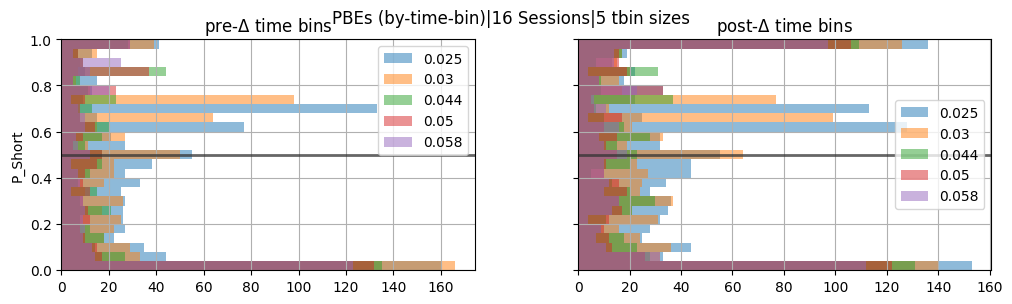

In [ ]:

@function_attributes(short_name=None, tags=['matplotlib', 'good', 'stacked-hist', 'ACTIVE'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-10-23 18:51', related_items=[])
def _perform_dual_hist_plot(grainularity_desc: str, laps_df: pd.DataFrame, ripple_df: pd.DataFrame):
    """ plots the stacked histograms for both laps and ripples
    """
    variable_name: str = 'P_Short'
    y_baseline_level: float = 0.5 # for P(short), etc
    y_ylims = (0, 1)

    # y_baseline_level: float = 0.0 # for wcorr, etc
    # y_ylims = (-1, 1)

    if is_dark_mode:
        baseline_kwargs = dict(color=(0.8,0.8,0.8,.75), linewidth=2)
    else:
        baseline_kwargs = dict(color=(0.2,0.2,0.2,.75), linewidth=2)
        
    def _update_stacked_hist_post_plot(histogram_out):
        """ captures: y_baseline_level, y_ylims """
        for k, ax in histogram_out.axes.items():
            _tmp_line = ax.axhline(y_baseline_level, **baseline_kwargs) # draw baseline line (horizontally)
            ax.set_ylim(*y_ylims)
            
    common_stacked_hist_kwargs = dict(figsize=(12, 3), column_name=variable_name)

    # You can use it like this:
    num_unique_sessions: int = laps_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
    num_unique_time_bins: int = laps_df.time_bin_size.nunique(dropna=True)
    _laps_histogram_out = plot_stacked_histograms(laps_df, f'Laps ({grainularity_desc})', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes", **common_stacked_hist_kwargs)
    _update_stacked_hist_post_plot(_laps_histogram_out)
    # fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')

    num_unique_sessions: int = ripple_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
    num_unique_time_bins: int = ripple_df.time_bin_size.nunique(dropna=True)
    _ripple_histogram_out = plot_stacked_histograms(ripple_df, f'PBEs ({grainularity_desc})', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes", **common_stacked_hist_kwargs)
    _update_stacked_hist_post_plot(_ripple_histogram_out)
    # fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

    return _laps_histogram_out, _ripple_histogram_out


matplotlib.use('Qt5Agg')
# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df)
# display(_laps_histogram_out)
# display(_ripple_histogram_out)
fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')


In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
# grainularity_desc: str = 'by-epoch'
# laps_df: pd.DataFrame = all_sessions_laps_df
# ripple_df: pd.DataFrame = all_sessions_ripple_df
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-epoch', laps_df=all_sessions_laps_df, ripple_df=all_sessions_ripple_df)
fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
all_sessions_ripple_time_bin_df['time_bin_size'].unique()

# Maintanence

In [ ]:
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass

all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
Assert.path_exists(all_session_experiment_experience_csv_path)
all_session_experiment_experience_df: pd.DataFrame = pd.read_csv(all_session_experiment_experience_csv_path) # , index_col=''
all_session_experiment_experience_df


In [ ]:
all_session_experiment_experience_df = KDibaOldDataSessionFormatRegisteredClass._add_session_good_bad_annotation_status(all_session_experiment_experience_df=all_session_experiment_experience_df)
all_session_experiment_experience_df

## save it back to file
all_session_experiment_experience_df.to_csv(all_session_experiment_experience_csv_path, index=False)